<a href="https://colab.research.google.com/github/kashyap333/FashionMNIST_PyTorch/blob/main/Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from torchvision import models
from timeit import default_timer as timer
import helper
from pathlib import Path 
import requests
from tqdm.auto import tqdm


In [49]:
if Path('Lazy_functions.py').is_file():
  print('file already is in the directory')

else:

  request = requests.get('https://raw.githubusercontent.com/kashyap333/Lazy_functions/main/lazy_functions.py')


  with open('lazy_functions.py', 'wb') as f:
    f.write(request.content)

from lazy_functions import plot_predictions, train_step, accuracy_fn, test_step, print_train_time

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [51]:
training_data = datasets.FashionMNIST(train = True,
                                      root = 'data',
                                      download = True,
                                      transform = transforms.ToTensor())
testing_data = datasets.FashionMNIST(train = False,
                                      root = 'data',
                                      download = True,
                                      transform = transforms.ToTensor())

In [52]:
class_names = training_data.classes
img, label = training_data[0]
img.shape

torch.Size([1, 28, 28])

In [53]:
len(training_data.data), len(testing_data.data), len(training_data.targets), len(testing_data.targets)

(60000, 10000, 60000, 10000)

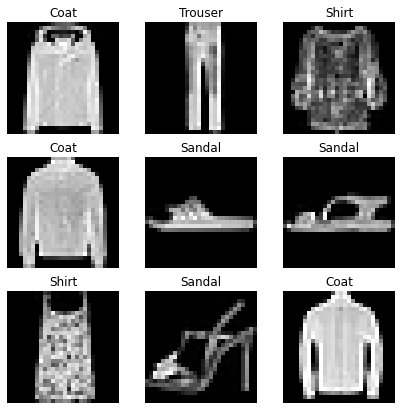

In [54]:
fig = plt.figure(figsize=(7, 7))
rows, columns = 3, 3
for i in range(1, rows*columns+1):
  id = torch.randint(0, len(training_data), size=[1]).item()
  img, label = training_data[id]
  fig.add_subplot(rows, columns, i)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(class_names[label])
  plt.axis(False)


In [55]:
BACTH_SIZE = 32

LEARNING_RATE = 0.1

EPOCHS = 3

In [56]:
train_loader = DataLoader(training_data, batch_size=BACTH_SIZE, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=BACTH_SIZE, shuffle=False)

In [57]:
batched_trian, batched_label = next(iter(train_loader))
batched_trian.shape, batched_label.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [58]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()

    self.conv_block_1 = nn.Sequential(
              nn.Conv2d(in_channels=input_shape, 
                        out_channels=hidden_units, 
                        kernel_size=3, # how big is the square that's going over the image?
                        stride=1, # default
                        padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
              nn.ReLU(),
              nn.Conv2d(in_channels=hidden_units, 
                        out_channels=hidden_units,
                        kernel_size=3,
                        stride=1,
                        padding=1),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2,stride=2) # default stride value is same as kernel_size
          )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):

    return self.classifier(self.conv_block_2(self.conv_block_1(x)))


In [59]:
torch.manual_seed(42)

model_0 =  TinyVGG(input_shape = 1,
                   hidden_units= 10,
                   output_shape=len(training_data.classes)).to(device)

Trying forward pass on a single image to check shape and just to see if it works

In [60]:
img_batch, label_batch = next(iter(train_loader))

img, label = img_batch, label_batch[0]
print(f"Single image shape: {img.shape}\n")

model_0.eval()
with torch.inference_mode():

  pred = model_0(img.to(device))

Single image shape: torch.Size([32, 1, 28, 28])



Loss and optimisers

In [61]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_0.parameters(), lr=LEARNING_RATE)

Training  Loop

In [62]:
torch.manual_seed(42)

start_time = timer()

for epoch in tqdm(range(EPOCHS)):

  print(f' Epochs_no : {epoch}')

  train_step(data_loader=train_loader, 
        model=model_0, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
    )
  test_step(data_loader=test_loader,
      model=model_0,
      loss_fn=loss_fn,
      accuracy_fn=accuracy_fn,
  )

end_time = timer()


total_train_time_model_1 = print_train_time(start=start_time,
                                            end=end_time,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

 Epochs_no : 0
Train loss: 0.59667 | Train accuracy: 78.29%
Test loss: 0.39901 | Test accuracy: 85.71%

 Epochs_no : 1
Train loss: 0.36258 | Train accuracy: 86.95%
Test loss: 0.34922 | Test accuracy: 87.18%

 Epochs_no : 2
Train loss: 0.32573 | Train accuracy: 88.25%
Test loss: 0.31573 | Test accuracy: 88.46%


Train time on cuda: 31.144 seconds


In [112]:
import random

test_samples = []
test_labels = []

for img, label in random.sample(list(testing_data), k=9):

  test_samples.append(img)
  test_labels.append(label)

In [113]:
def make_predictions(model: torch.nn.Module, data, device:torch.device=device):

  pred_probability = []

  model.eval()
  with torch.inference_mode():
    for img in data:
      img = torch.unsqueeze(img, dim=0).to(device)

      logits = model(img)

      pred_prob = torch.softmax(logits.squeeze(), dim=0)

      pred_probability.append(pred_prob.cpu())

  return torch.stack(pred_probability)

In [114]:
predicitions = make_predictions(model = model_0, data = test_samples, device=device)

In [115]:
pred_classes = predicitions.argmax(dim=1)

In [116]:
test_labels, pred_classes

([5, 3, 1, 9, 2, 7, 3, 8, 3], tensor([5, 3, 1, 9, 2, 7, 3, 8, 3]))

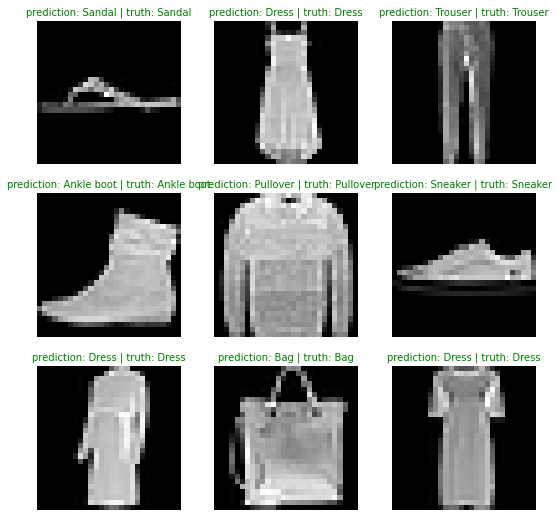

In [117]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  plt.imshow(sample.squeeze(), cmap='gray')

  pred_labels = class_names[pred_classes[i]]

  true_labels = class_names[test_labels[i]]

  title = f'prediction: {pred_labels} | truth: {true_labels}'


  if pred_labels == true_labels:

    plt.title(title, c='g', size=10)

  else:

    plt.title(title, c='r', size=10)

  plt.axis(False);
  
